## Homework 1 - Solutions

## Problem 1

We will start by estimating the uncertainty, reliability and resolution
Then the Brier score is simply = uncertainty + reliability - resolution

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

#dataset = pd.read_csv("https://projects.fivethirtyeight.com/nfl-api/nfl_elo.csv")
dataset = pd.read_csv("nfl_elo.csv")
print(len(dataset))

16274


We filter data only after the 2010 season and create a column that keeps track of which team won the game

In [2]:
data_mask = dataset['season'] >= 2010
data = dataset[data_mask]
data['win1'] = data.apply(lambda row: int(row.score1 > row.score2), axis=1)

Calculate uncertainty

In [3]:
# base rate
br = float(sum(data.win1))/len(data)
uncertainty = (1-br)*br

Calculate reliability and resolution

In [4]:
# we will use bins that cover 10% probability
# we start from 0.1 since the minimum predicted probability is > 0.1
bins = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

reliability = 0
resolution = 0

for b in range(1,len(bins)):
        bin_mask = (data['elo_prob1'] >= bins[b-1]) & (data['elo_prob1'] < bins[b])
        tmp = data[bin_mask]
        nk = len(tmp)
        pk = np.mean(tmp['elo_prob1'])
        ok = float(sum(tmp.win1))/len(tmp)
        reliability += nk*pow((pk-ok),2)
        resolution += nk*pow((ok-br),2)

reliability /= float(len(data))
resolution /= float(len(data))
brier_score = reliability - resolution + uncertainty

print("Brier Score: \t", round(brier_score,5))
print("Reliability: \t", round(reliability,5))
print("Resolution: \t", round(resolution,5))
print("Uncertainty: \t", round(uncertainty,5))

Brier Score: 	 0.22029
Reliability: 	 0.00077
Resolution: 	 0.02483
Uncertainty: 	 0.24436


Calculate the accuracy, i.e., how many times the prediction of the elo model was correct

In [5]:
# we create a new column that will be 1 if the model predicted team1 to win and 0 otherwise
data['pwin1'] = data.apply(lambda row: int(row.elo_prob1 > 0.5), axis=1)
accuracy = len(data[data.pwin1 == data.win1])/float(len(data))
print("Accuracy: \t", accuracy)

Accuracy: 	 0.6450270495214315


The reliability curve has on the x-axis the predicted probability, and the y-axis the observed probability

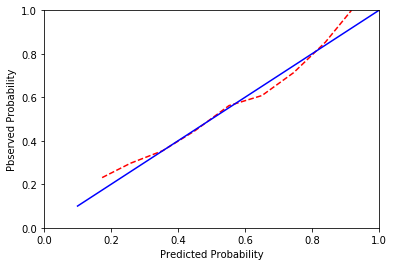

In [6]:
predicted_prob = []
observed_prob = []

for b in range(1,len(bins)):
        bin_mask = (data['elo_prob1'] >= bins[b-1]) & (data['elo_prob1'] < bins[b])
        tmp = data[bin_mask]
        predicted_prob.append(np.mean(tmp['elo_prob1']))
        observed_prob.append(len(tmp[tmp.win1 == 1])/float(len(tmp)))

fig = plt.figure()
ax = fig.add_subplot(111)
# the blue curve is the y=x, i.e., perfect calibration
plt.plot(predicted_prob,observed_prob,'r--',bins,bins,'b')
plt.axis([0, 1, 0, 1])
ax.set_xlabel('Predicted Probability')
ax.set_ylabel('Pbserved Probability')
plt.show()


## Problem 2

Here we have to essentially examine whether version A and version B have (statistically) different conversion rates. The observed conversion rates are: 

In [7]:
convA = 1320/3250.0
convB = 1250/2870.0
print("Conversion rate A: \t", round(convA,3))
print("Conversion rate B: \t", round(convB,3))

Conversion rate A: 	 0.406
Conversion rate B: 	 0.436


We now will perform an empirical (i.e., through simulations) statistical test. Since we want to see whether the two sites have different conversion rate (statistically) we can assume that version B has the conversion rate observed for version A (H_0). So our test is:

H_0: convB = 0.406
H_1: convB != 0.406

Under the null assumption, i.e., that the two version have the same conversion rate, the probability of observing at least 1250 customers buying from version B is:  0.0007


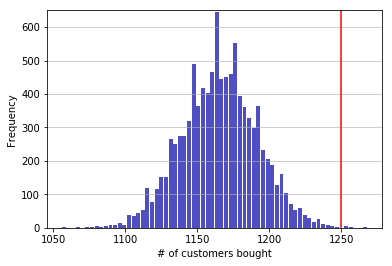

In [8]:
# we simulate 10,000 sets of 2,870 customers and we will see how possible is to observe 1,250 (or more) customers each time

sim_bought = np.random.binomial(2870, 0.406,10000)

# we can now find how many of those simulations ended up with at least 1250 customers, i.e., the number of customers observed in reality

empirical_pval = len(sim_bought[sim_bought>=1250])/10000.0

n, bins, patches = plt.hist(x=sim_bought, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('# of customers bought')
plt.ylabel('Frequency')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
plt.axvline(x=1250, c='red')

print("Under the null assumption, i.e., that the two version have the same conversion rate, the probability of observing at least 1250 customers buying from version B is: ", empirical_pval)

This probability is fairly small, which leads us to rejecting the null hypothesis. I.e., the two versions of the website have different conversion rates.

The above solution is correct for the purposes of the homework. However, there is one subtle point. We have assumed that the real conversion rate of website A is 0.406. Nevertheless, this comes with some uncertainty too. The best is to examine directly the difference of the proportions. I.e., perform the test:

H_0: convA - convB = 0

H_1: convA - convB != 0

This requires simulating both versions. However in our simulations we need to start with the assumption that convA and convB. For this we use the pooled proportion as the conversion rate for both versions.

0.4199346405228758
Under the null assumption, i.e., that the two version have the same conversion rate, the probability of observing a difference in the conversion rates of -2.9% or less is:  0.0078


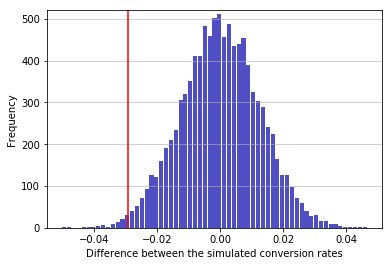

In [9]:
pooled_conv = (1320+1250)/float(3250+2870)
print(pooled_conv)

sim_convA = np.random.binomial(3250, pooled_conv, 10000)/3250.0
sim_convB = np.random.binomial(2870, pooled_conv, 10000)/2870.0
conv_diff = sim_convA-sim_convB
conv_observed = convA-convB

n, bins, patches = plt.hist(x=conv_diff, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Difference between the simulated conversion rates')
plt.ylabel('Frequency')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
plt.axvline(x=conv_observed, c='red')

empirical_pval = len(conv_diff[conv_diff<=conv_observed])/10000.0
print("Under the null assumption, i.e., that the two version have the same conversion rate, the probability of observing a difference in the conversion rates of -2.9% or less is: ", empirical_pval)

Again probability is fairly small, which leads us to rejecting the null hypothesis. I.e., the two versions of the website have different conversion rates, similar to the conclusion above. A third possible way of doing this, without any simulation is to use the z-score for 2 population proportions as explained here: https://www.socscistatistics.com/tests/ztest/ If you perform the test again you will reject the null hypothesis of equal conversion rates. 

## Problem 3

For solving this problem we will make use of the Bayes rule.  Initially, we do not know anything about the machines, and hence, each machine is equally-probable to be the high-payout machine, i.e., our prior is Pr(M1)=Pr(M2)=0.5. 
We throw a coin to machine M1 (due to symmetry the same would be if we experimented with M2). 

Case 1: No pay out

In this case the "evidence" we have is that we played and the machine did not payout (event: ~P). Hence, we have to calculate: Pr(M1|~P). This equals: 
Pr(M1|~P)=Pr(~P|M1)Pr(M1)/Pr(~P), 

where: 
* Pr(~P|M1) = 0.85, since this is the conditional probability of not winning given that M1 is the high payout machine
* Pr(M1) = 0.5, our prior 
* Pr(~P) = Pr(~P|M1)P(M1) + Pr(~P|M2)P(M2) = 0.85\*0.5 + 0.95\*0.5 = , is the total probability of not winning (law of total probability)  

In [10]:
print("The posterior probability of machine 1 being the high payout machine is: ", round((0.85*0.5)/((0.85*0.5)+(0.95*0.5)),3))

The posterior probability of machine 1 being the high payout machine is:  0.472


Case 2: 

In this case the evidence is that we win after playing M1 (event P). Hence, Pr(M1|P) = Pr(P|M1)Pr(M1)/Pr(P)

where:
* Pr(P|M1) = 0.15
* Pr(M1) = 0.5
* Pr(P) = Pr(P|M1)P(M1)+Pr(P|M2)P(M2) = 0.15\*0.5+0.05\*0.5

In [11]:
print("The posterior probability of machine 1 being the high payout machine is: ", round((0.15*0.5)/((0.15*0.5)+(0.05*0.5)),3))

The posterior probability of machine 1 being the high payout machine is:  0.75
